In [9]:
import xarray
from dask.distributed import Client
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import random
from preprocess.etc import benchmark
from shutil import rmtree

random.seed(0)

def train_test_split(ds):
    def last_day_of_month(any_day):
        # The day 28 exists in every month. 4 days later, it's always next month
        next_month = any_day.replace(day=28) + timedelta(days=4)
        # subtracting the number of the current day brings us back one month
        return next_month - timedelta(days=next_month.day)

    timeindex = ds.indexes["time"]
    dt_start = ds.time.min().values
    dt_end = ds.time.max().values
    month_dr = pd.date_range(start=dt_start, end=dt_end, freq="M")  # monthly daterange

    train_ls = []
    test_ls = []

    for month in month_dr:
        start = datetime(month.year, month.month, 1)
        end = last_day_of_month(start) + timedelta(hours=23, minutes=59, seconds=59)
        test = end - timedelta(days=7)

        idxstart = timeindex.get_slice_bound(start, "left")
        idxtest = timeindex.get_slice_bound(test, "left")
        idxend = timeindex.get_slice_bound(end, "left")

        train_ls.extend([i for i in range(idxstart, idxtest)])
        test_ls.extend([i for i in range(idxtest, idxend)])

        # train_ls.append(slice(start, test)) # first ~3 weeks
        # test_ls.append(slice(test, end)) # last week of the month

    ds_train = ds.isel(time=train_ls)
    ds_test = ds.isel(time=test_ls)

    return ds_train, ds_test


def shuffle_timeindex(ds):
    num = len(ds.time)
    samples = random.sample(range(num), num)

    return ds.isel(time=samples)

In [3]:
full_ds = xarray.open_zarr("/scratch/snx3000/kschuurm/DATA/HRSEVIRI.zarr")

In [10]:
for var in full_ds:
    del full_ds[var].encoding["chunks"]

i = len(full_ds.time)
full_ds = full_ds.dropna(dim="time", how="all", subset=["SIS"])

print("dropped", (1 - len(full_ds.time) / i)*100)

half_ds = full_ds.sel(
    time=slice(datetime(2015, 1, 1, 0, 0), None)
)  # 2014 is used as test
test_ds = full_ds.sel(
    time=slice(datetime(2014, 1, 1, 0, 0, 0), datetime(2015, 1, 1, 0, 0))
)

train_ds, valid_ds = train_test_split(half_ds)



dropped 49.082466774175614


In [11]:
patch_size = (16, 16)
batch_size = 256

In [12]:
with benchmark('val'):
    valid_ds.chunk({'time':batch_size, 'lat':patch_size[0], 'lon':patch_size[1]}).to_zarr("/scratch/snx3000/kschuurm/DATA/valid.zarr", mode="w", safe_chunks=True)

val : 77.395 seconds


In [13]:
with benchmark('test'):
    test_ds.chunk({'time':batch_size, 'lat':patch_size[0], 'lon':patch_size[1]}).to_zarr("/scratch/snx3000/kschuurm/DATA/test.zarr", mode="w", safe_chunks=True)

test : 293.159 seconds


In [14]:
with benchmark('train'):
    train_ds.chunk({'time':10, 'lat':-1, 'lon':-1}).to_zarr("/scratch/snx3000/kschuurm/DATA/train.zarr", mode="w", safe_chunks=True)

train : 194.252 seconds


In [15]:
with benchmark('shuffle'):
    train_ds = xarray.open_zarr("/scratch/snx3000/kschuurm/DATA/train.zarr")
    train_ds = shuffle_timeindex(train_ds)
    train_ds.chunk({'time':10, 'lat':-1, 'lon':-1}).to_zarr("/scratch/snx3000/kschuurm/DATA/train_shuffle.zarr", mode="w", safe_chunks=True)

shuffle : 121.700 seconds


In [16]:
with benchmark('chunk again'):
    train_ds = xarray.open_zarr("/scratch/snx3000/kschuurm/DATA/train_shuffle.zarr")
    for var in train_ds:
        del train_ds[var].encoding["chunks"]

    train_ds.chunk({'time':batch_size, 'lat':patch_size[0], 'lon':patch_size[1]}).to_zarr("/scratch/snx3000/kschuurm/DATA/train.zarr", mode='w', safe_chunks=True)
    
    rmtree("/scratch/snx3000/kschuurm/DATA/train_shuffle.zarr") #remove temp

chunk again : 154.902 seconds


In [ ]:
## TESTING

In [20]:
train_ds = xarray.open_zarr("/scratch/snx3000/kschuurm/DATA/train.zarr")

In [21]:
a = train_ds.SZA < np.deg2rad(85)
import matplotlib.pyplot as plt

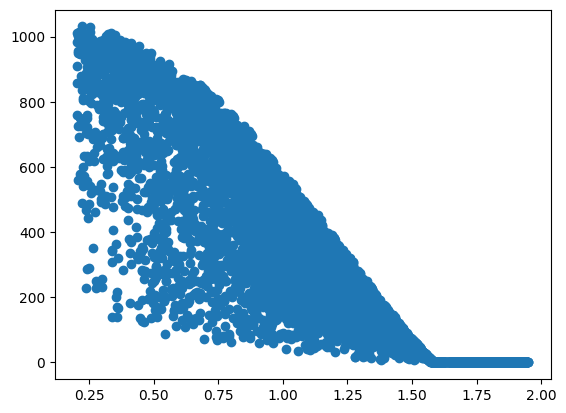

In [22]:
plt.scatter(train_ds.SZA[:,1,0], train_ds.SIS[:,1,0])

In [70]:
a = (train_ds.SIS[:,0,0] <2) & (train_ds.SIS[:,0,0] > 0) & (train_ds.SZA[:,0,0] <.5)

In [13]:
full_ds.SIS[10,:,:].values

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [72]:
zeros

<xarray.Dataset>
Dimensions:        (time: 60, lat: 503, lon: 801)
Coordinates:
  * lat            (lat) float64 35.03 35.08 35.13 35.19 ... 61.86 61.91 61.97
  * lon            (lon) float64 -14.97 -14.92 -14.87 ... 27.87 27.92 27.97
  * time           (time) datetime64[ns] 2015-05-15T14:12:00 ... 2015-05-15T1...
Data variables: (12/17)
    AZI            (time, lat, lon) float16 dask.array<chunksize=(4, 64, 64), meta=np.ndarray>
    CAL            (time, lat, lon) float32 dask.array<chunksize=(4, 64, 64), meta=np.ndarray>
    SIS            (time, lat, lon) float32 dask.array<chunksize=(4, 64, 64), meta=np.ndarray>
    SRTM           (lat, lon) float64 dask.array<chunksize=(64, 64), meta=np.ndarray>
    SZA            (time, lat, lon) float16 dask.array<chunksize=(4, 64, 64), meta=np.ndarray>
    channel_1      (time, lat, lon) float32 dask.array<chunksize=(4, 64, 64), meta=np.ndarray>
    ...             ...
    channel_5      (time, lat, lon) float32 dask.array<chunksize=(4, 64, 64), meta=np.ndarray>
    channel_6      (time, lat, lon) float32 dask.array<chunksize=(4, 64, 64), meta=np.ndarray>
    channel_7      (time, lat, lon) float32 dask.array<chunksize=(4, 64, 64), meta=np.ndarray>
    channel_8      (time, lat, lon) float32 dask.array<chunksize=(4, 64, 64), meta=np.ndarray>
    channel_9      (time, lat, lon) float32 dask.array<chunksize=(4, 64, 64), meta=np.ndarray>
    record_status  (time) int8 dask.array<chunksize=(4,), meta=np.ndarray>

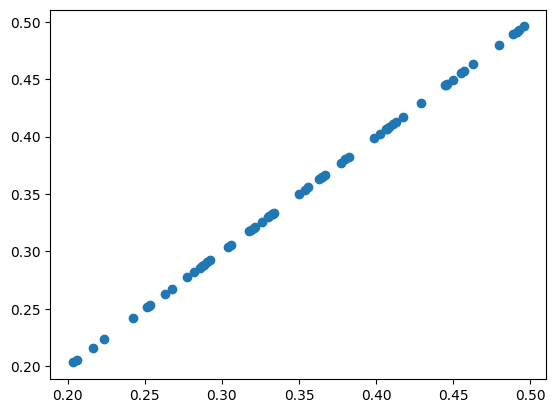

In [73]:
plt.scatter(zeros.SZA[:,0,0], zeros.SIS[:,0,0])

In [77]:
zeros

<xarray.Dataset>
Dimensions:        (time: 60, lat: 503, lon: 801)
Coordinates:
  * lat            (lat) float64 35.03 35.08 35.13 35.19 ... 61.86 61.91 61.97
  * lon            (lon) float64 -14.97 -14.92 -14.87 ... 27.87 27.92 27.97
  * time           (time) datetime64[ns] 2015-05-15T14:12:00 ... 2015-05-15T1...
Data variables: (12/17)
    AZI            (time, lat, lon) float16 dask.array<chunksize=(4, 64, 64), meta=np.ndarray>
    CAL            (time, lat, lon) float32 dask.array<chunksize=(4, 64, 64), meta=np.ndarray>
    SIS            (time, lat, lon) float32 dask.array<chunksize=(4, 64, 64), meta=np.ndarray>
    SRTM           (lat, lon) float64 dask.array<chunksize=(64, 64), meta=np.ndarray>
    SZA            (time, lat, lon) float16 dask.array<chunksize=(4, 64, 64), meta=np.ndarray>
    channel_1      (time, lat, lon) float32 dask.array<chunksize=(4, 64, 64), meta=np.ndarray>
    ...             ...
    channel_5      (time, lat, lon) float32 dask.array<chunksize=(4, 64, 64), meta=np.ndarray>
    channel_6      (time, lat, lon) float32 dask.array<chunksize=(4, 64, 64), meta=np.ndarray>
    channel_7      (time, lat, lon) float32 dask.array<chunksize=(4, 64, 64), meta=np.ndarray>
    channel_8      (time, lat, lon) float32 dask.array<chunksize=(4, 64, 64), meta=np.ndarray>
    channel_9      (time, lat, lon) float32 dask.array<chunksize=(4, 64, 64), meta=np.ndarray>
    record_status  (time) int8 dask.array<chunksize=(4,), meta=np.ndarray>

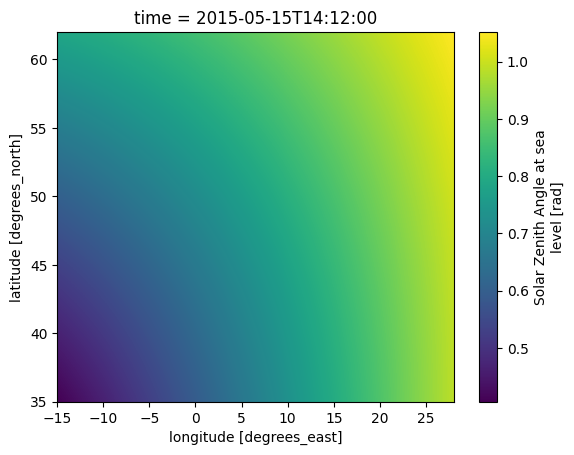

In [76]:
zeros.SZA[0,:,:].plot.imshow()